<a href="https://colab.research.google.com/github/ziad347/DA499_project/blob/main/Copy_of_project_graduation_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/umairshahpirzada/traffic-net')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omaralshorman
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/umairshahpirzada/traffic-net


100%|██████████| 48.4M/48.4M [00:00<00:00, 1.28GB/s]

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# For Kaggle, the dataset is typically mounted in the input directory
# Adjust these paths based on your Kaggle dataset structure
dataset_dir ='/content/traffic-net/trafficnet_dataset_v1'
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")


In [ ]:
# ------------ EXPLORATORY DATA ANALYSIS ------------

print("\n--- EXPLORATORY DATA ANALYSIS ---\n")

# List all classes (subdirectories)
classes = os.listdir(train_dir)
classes = [cls for cls in classes if os.path.isdir(os.path.join(train_dir, cls))]
print(f"Classes found: {classes}")

# Count images in each class
class_counts = {}
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[cls] = num_images

# Convert to DataFrame and display
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df_counts = df_counts.reset_index().rename(columns={'index': 'Class'})
df_counts = df_counts.sort_values('Count', ascending=False)

print("\nImage count per class:")
print(df_counts)

# Check image dimensions
dimensions = []
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    if images:  # Make sure there are images in this class
        # Sample a few images
        sampled_images = random.sample(images, min(5, len(images)))
        for img_name in sampled_images:
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            dimensions.append((img.width, img.height))

# Get unique dimensions
unique_dims = list(set(dimensions))

print("\nSample of image dimensions found in the dataset:")
for dim in unique_dims:
    count = dimensions.count(dim)
    print(f"  {dim}: {count} samples")



--- EXPLORATORY DATA ANALYSIS ---

Classes found: ['dense_traffic', 'sparse_traffic', 'fire', 'accident']

Image count per class:
            Class  Count
1  sparse_traffic    901
0   dense_traffic    900
2            fire    900
3        accident    900

Sample of image dimensions found in the dataset:
  (299, 168): 3 samples
  (318, 159): 1 samples
  (314, 161): 1 samples
  (275, 183): 2 samples
  (254, 199): 1 samples
  (232, 218): 1 samples
  (288, 175): 1 samples
  (300, 168): 5 samples
  (259, 194): 4 samples
  (299, 169): 1 samples



--- DATA VISUALIZATION ---



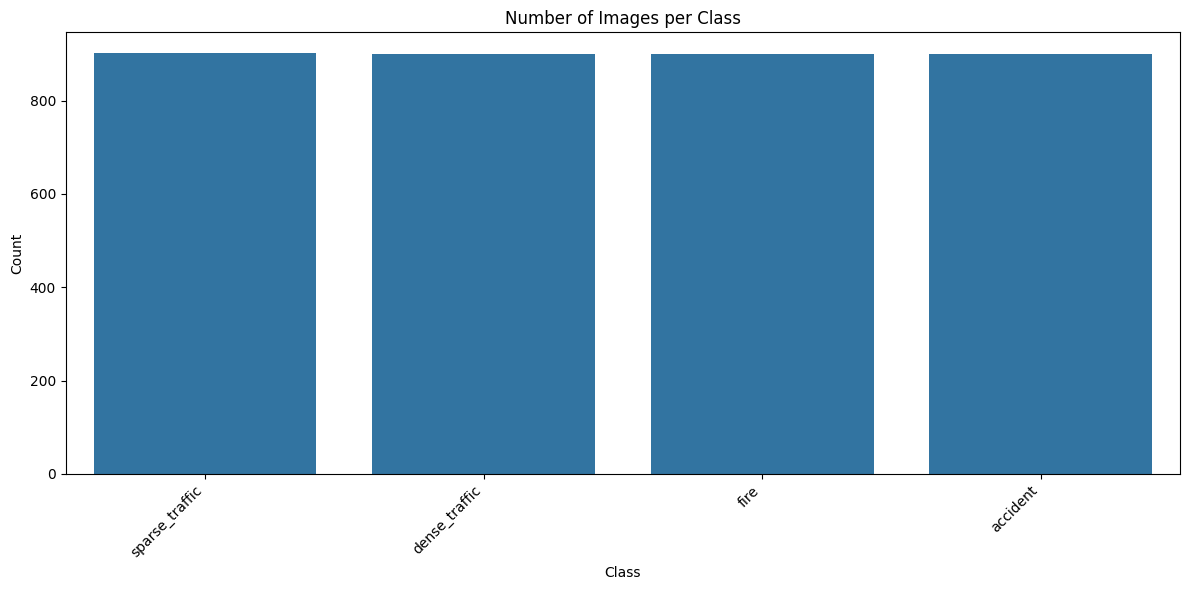

In [ ]:
# ------------ DATA VISUALIZATION ------------

print("\n--- DATA VISUALIZATION ---\n")
# Visualize the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=df_counts)
plt.title('Number of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# ------------ MODEL BUILDING ------------

print("\n--- MODEL BUILDING ---\n")
IMG_SIZE = 64  # Or any other desired image size (e.g., 128, 224)
num_classes = len(classes)  # Get the number of classes from your previous code

# Build a custom CNN model
print("Building custom CNN model...")
cnn_model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu',  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu' ),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

# Build a transfer learning model
print("\nBuilding transfer learning model with MobileNetV2...")
# Load the pre-trained model without the top classification layer
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top
transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()


--- MODEL BUILDING ---

Building custom CNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,504,676 (13.37 MB)

 Trainable params: 3,502,756 (13.36 MB)

 Non-trainable params: 1,920 (7.50 KB)


Building transfer learning model with MobileNetV2...


<ipython-input-7-b1e3bb064ca2>:54: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,972 (9.87 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [ ]:
# ------------ MODEL TRAINING ------------
'''
print("\n--- MODEL TRAINING ---\n")
# Create callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the model
print("Training the CNN model (this may take some time)...")
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

trained_model = cnn_model

# Plot training history
print("Plotting training history...")
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()'''



--- MODEL TRAINING ---

Found 3600 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Training the CNN model (this may take some time)...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5357 - loss: 1.5734
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 149ms/step - accuracy: 0.5364 - loss: 1.5706 - val_accuracy: 0.2500 - val_loss: 6.4741 - learning_rate: 0.0010
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7031 - loss: 0.8831
Epoch 2: val_accuracy did not improve from 0.25000
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.7031 - loss: 0.8830 - val_accuracy: 0.2500 - val_loss: 6.3660 - learning_rate: 0.0010
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7534 - loss: 0.7084
Epoch 3: val_accuracy improved from 0.25000 to 0.35375, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7533 - loss: 0.7087 - val_accuracy: 0.3537 - val_loss: 2.3334 - learning_rate: 0.0010
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7421 - loss: 0.6812
Epoch 4: val_accuracy improved from 0.35375 to 0.59375, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.7421 - loss: 0.6812 - val_accuracy: 0.5938 - val_loss: 1.4259 - learning_rate: 0.0010
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7680 - loss: 0.6139
Epoch 5: val_accuracy improved from 0.59375 to 0.69875, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.7680 - loss: 0.6139 - val_accuracy: 0.6988 - val_loss: 0.8675 - learning_rate: 0.0010
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7820 - loss: 0.5917
Epoch 6: val_accuracy improved from 0.69875 to 0.74000, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.7821 - loss: 0.5916 - val_accuracy: 0.7400 - val_loss: 0.7438 - learning_rate: 0.0010
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7977 - loss: 0.5531
Epoch 7: val_accuracy improved from 0.74000 to 0.75250, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7977 - loss: 0.5531 - val_accuracy: 0.7525 - val_loss: 0.7004 - learning_rate: 0.0010
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7962 - loss: 0.5411
Epoch 8: val_accuracy did not improve from 0.75250
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.7962 - loss: 0.5411 - val_accuracy: 0.7412 - val_loss: 0.7612 - learning_rate: 0.0010
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8043 - loss: 0.5156
Epoch 9: val_accuracy improved from 0.75250 to 0.76125, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8044 - loss: 0.5154 - val_accuracy: 0.7613 - val_loss: 0.7419 - learning_rate: 0.0010
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8253 - loss: 0.4761
Epoch 10: val_accuracy did not improve from 0.76125

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8253 - loss: 0.4761 - val_accuracy: 0.7025 - val_loss: 0.9367 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.
Plotting training history...


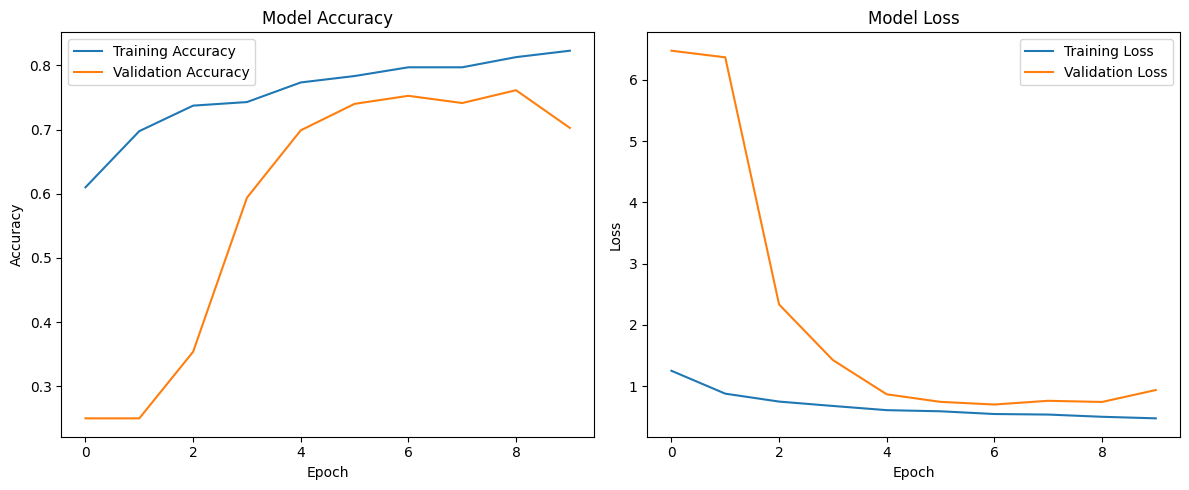

In [ ]:
# ------------ MODEL TRAINING ------------

print("\n--- MODEL TRAINING ---\n")
# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,  # Adjust as needed
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

val_gen = val_datagen.flow_from_directory(
    test_dir,  # Or your validation data directory
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,  # Adjust as needed
    class_mode='categorical'
)
# Create callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the model
print("Training the CNN model (this may take some time)...")
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

trained_model = cnn_model

# Plot training history
print("Plotting training history...")
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


--- MODEL EVALUATION ---

Found 800 images belonging to 4 classes.
 4/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9271 - loss: 0.2571

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8418 - loss: 0.4962
Test accuracy: 0.7613
Test loss: 0.7419
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

Classification Report:
                precision    recall  f1-score   support

      accident       0.61      0.93      0.74       200
 dense_traffic       0.82      0.77      0.79       200
          fire       0.95      0.70      0.80       200
sparse_traffic       0.79      0.66      0.72       200

      accuracy                           0.76       800
     macro avg       0.79      0.76      0.76       800
  weighted avg       0.79      0.76      0.76       800



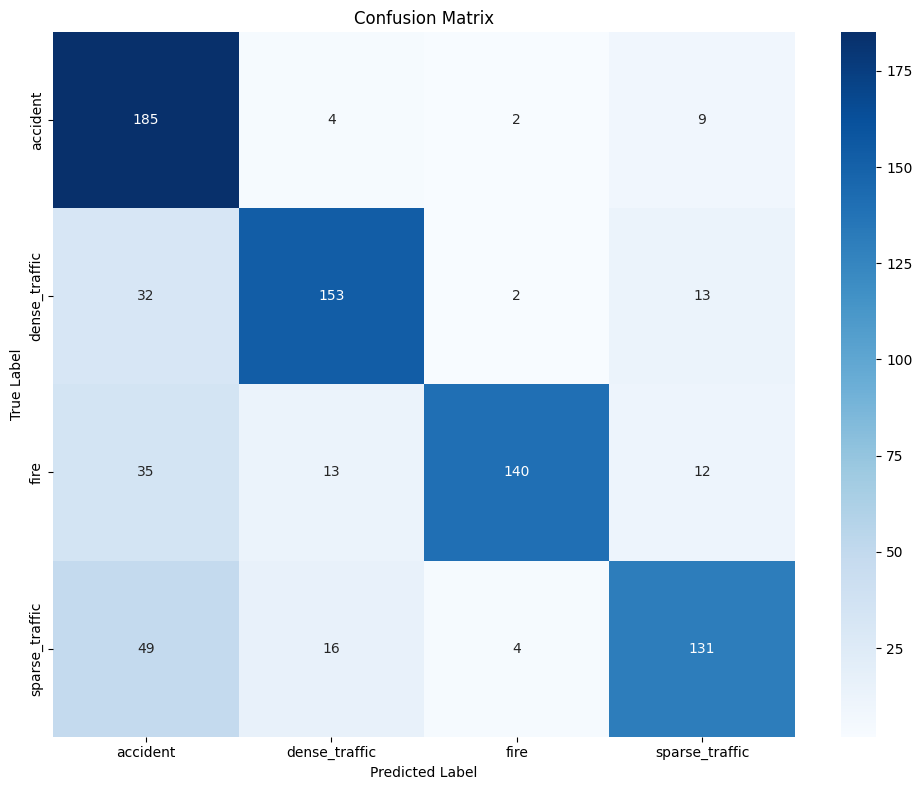

In [ ]:
# ------------ MODEL EVALUATION & PREDICTION ------------

print("\n--- MODEL EVALUATION ---\n")

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,  # Adjust as needed
    class_mode='categorical',
    shuffle=False # Important to set shuffle to False for evaluation
)

# Evaluate the model
test_loss, test_acc = trained_model.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get predictions
predictions = trained_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Create classification report
print("\nClassification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Create confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()



--- PREDICTIONS ON SAMPLE IMAGES ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


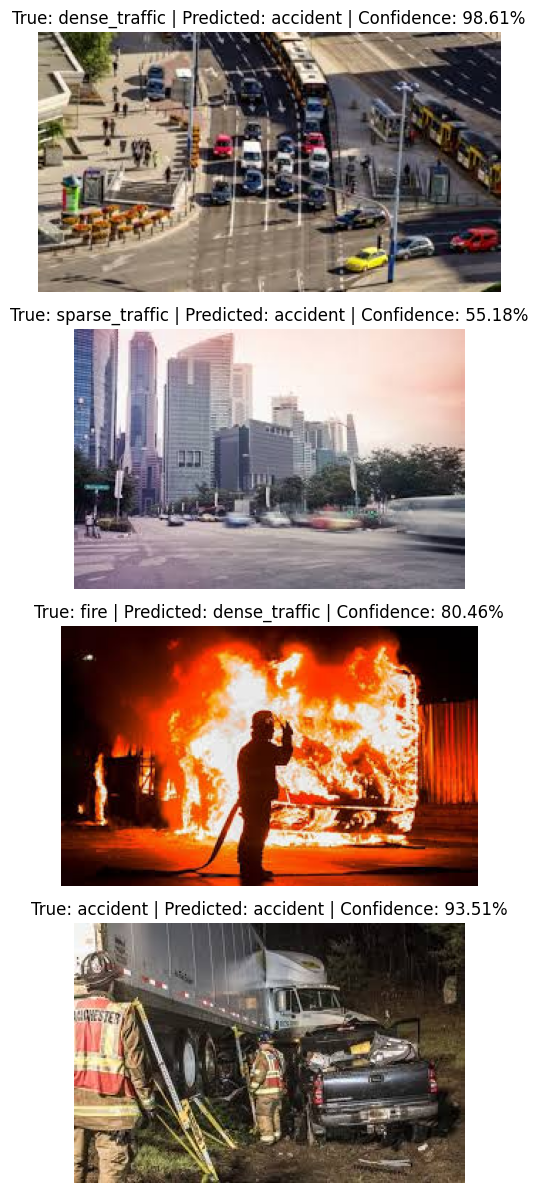

In [ ]:
# ------------ MAKING PREDICTIONS ON NEW IMAGES ------------

print("\n--- PREDICTIONS ON SAMPLE IMAGES ---\n")

plt.figure(figsize=(15, 5 * 3))

# Get subdirectories (classes)
classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

sample_count = 0
row = 0
num_samples = 5

# Get class indices from the test generator
class_indices = test_gen.class_indices  # Add this line


for cls in classes:
    if sample_count >= num_samples:
        break

    class_dir = os.path.join(test_dir, cls)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    if not images:
        continue

    # Sample an image
    img_name = random.choice(images)
    img_path = os.path.join(class_dir, img_name)

    # Load and display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Make prediction
    # Load and preprocess the image
    img_for_pred = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_for_pred = img_for_pred / 255.0  # Normalize
    img_for_pred = np.expand_dims(img_for_pred, axis=0)  # Add batch dimension

    # Make prediction
    prediction = trained_model.predict(img_for_pred)
    predicted_class_idx = np.argmax(prediction[0])

    # Get class name
    class_names = {v: k for k, v in class_indices.items()}
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx] * 100

    # Display the image with prediction
    row += 1
    plt.subplot(num_samples, 1, row)
    plt.imshow(img)
    plt.title(f"True: {cls} | Predicted: {predicted_class} | Confidence: {confidence:.2f}%")
    plt.axis('off')

    sample_count += 1

plt.tight_layout()
plt.show()


--- TRAINING TRANSFER LEARNING MODEL ---

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5478 - loss: 1.3345
Epoch 1: val_accuracy did not improve from 0.76125
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.5486 - loss: 1.3321 - val_accuracy: 0.7212 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7369 - loss: 0.7503
Epoch 2: val_accuracy did not improve from 0.76125
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.7369 - loss: 0.7504 - val_accuracy: 0.7275 - val_loss: 0.7453 - learning_rate: 0.0010
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7576 - loss: 0.6659
Epoch 3: val_accuracy did not improve from 0.76125
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.7576 - loss: 0.6661 - val_accuracy: 0.7400 - val_loss: 0.7267 - learning_rate: 0.0010
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7670 - loss: 0.6093
Epoch 4: val_accuracy did not im

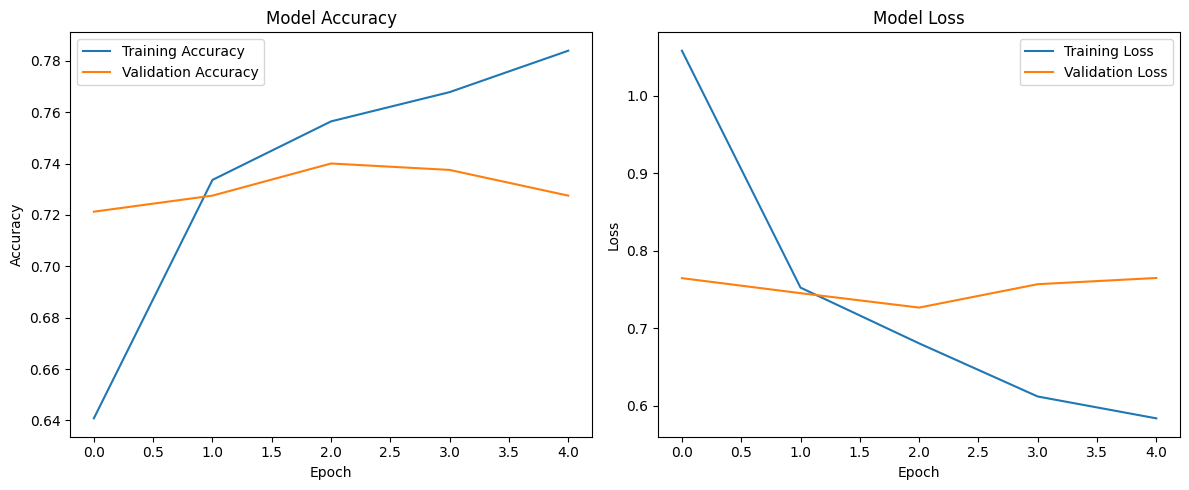


--- EVALUATING TRANSFER LEARNING MODEL ---

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7190 - loss: 0.7477
Test accuracy: 0.7400
Test loss: 0.7267
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step

Classification Report:
                precision    recall  f1-score   support

      accident       0.66      0.75      0.70       200
 dense_traffic       0.76      0.69      0.72       200
          fire       0.92      0.80      0.86       200
sparse_traffic       0.67      0.72      0.69       200

      accuracy                           0.74       800
     macro avg       0.75      0.74      0.74       800
  weighted avg       0.75      0.74      0.74       800



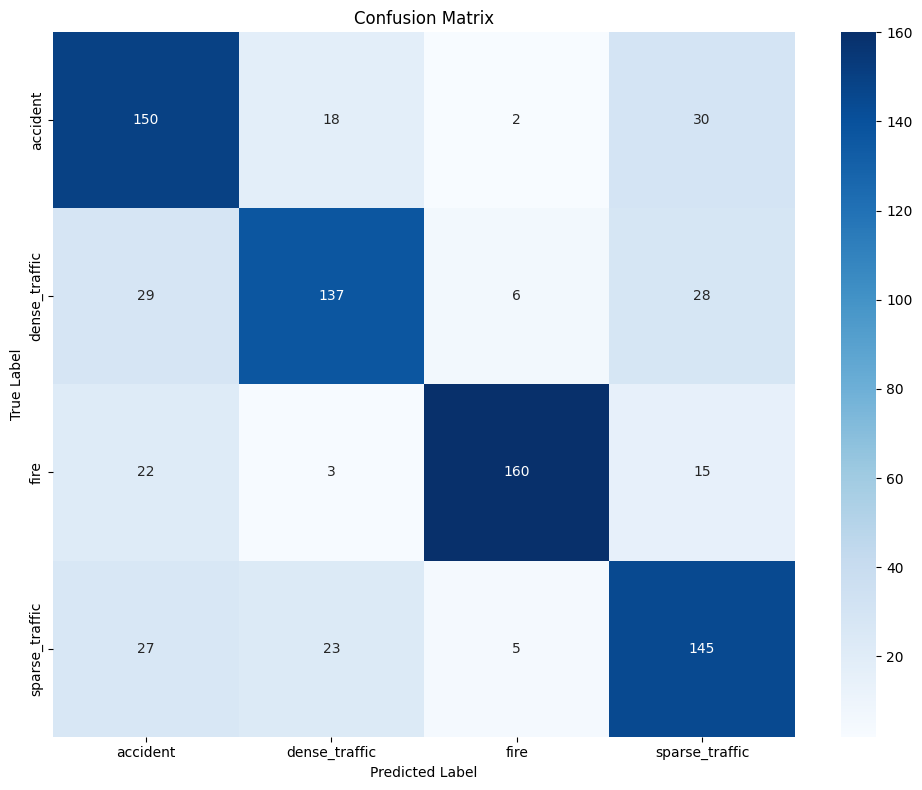


--- MODEL COMPARISON ---

Custom CNN Accuracy: 0.7613
Transfer Learning Accuracy: 0.7400
Best model saved as 'best_traffic_net_model.h5'


In [ ]:
# ------------ TRANSFER LEARNING MODEL ------------
# Train and evaluate the transfer learning model
print("\n--- TRAINING TRANSFER LEARNING MODEL ---\n")
transfer_history = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

transfer_trained_model = transfer_model

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['accuracy'], label='Training Accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['loss'], label='Training Loss')
plt.plot(transfer_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("\n--- EVALUATING TRANSFER LEARNING MODEL ---\n")
# Evaluate the model
transfer_loss, transfer_accuracy = transfer_trained_model.evaluate(test_gen)
print(f"Test accuracy: {transfer_accuracy:.4f}")
print(f"Test loss: {transfer_loss:.4f}")

# Get predictions
predictions = transfer_trained_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Create classification report
print("\nClassification Report:")
transfer_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(transfer_report)

# Create confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Compare the two models
print("\n--- MODEL COMPARISON ---\n")
print(f"Custom CNN Accuracy: {test_acc:.4f}")
print(f"Transfer Learning Accuracy: {transfer_accuracy:.4f}")

# Save the best model
best_model = transfer_trained_model if transfer_accuracy > test_acc else trained_model
best_model.save('best_traffic_net_model.h5')
print("Best model saved as 'best_traffic_net_model.h5'")
